# Allen atlas image regression

## 1. Opening AllenSDK, Packages and Isocortex map

In [1]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
import ants
import nrrd
import scipy
import cv2
from PIL import Image
from EasyROI import EasyROI
from plantcv import plantcv as pcv
import nrrd
from polyroi import Shape

In [2]:
experiment_name = "test1_M36"

In [3]:
#directory = search_for_file_path()
rsp, tree = open_AllenSDK() #resolution of annotation can be changed with karg resolution. default = 25 micrometer
isocortex_map, id_name_dict, bregma = map_generator(rsp, tree, structure='Isocortex', depth=3)

#sma_mask = create_mask(isocortex_map, 656)
contour = create_contour(isocortex_map)
contour = contour.astype(np.uint8)

['annotation_25.nrrd']


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 2172.90it/s]


## 2. Plotting regions and contours for open_AllenSDK validation

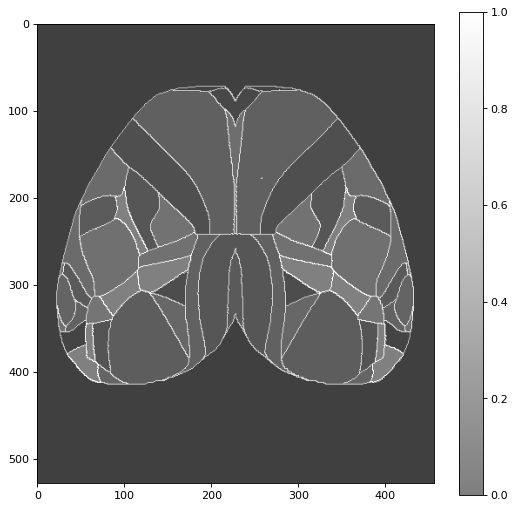

In [4]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
plt.imshow(isocortex_map,vmax=1300, cmap='gray', alpha=0.5)
plt.imshow(contour, cmap='binary_r', alpha=0.5)
plt.colorbar()
plt.show()

## 3. Changing to local directory to save images and automate process

#### (Also creates a new folder named experiment_name if it does not exist yet)

In [5]:
# Changing directory for local_dir (where every registration will be made)
local_dir='/Users/vincentchouinard/Documents/Maitrise/Registration'
os.chdir(local_dir)


newfolderpath = "".join([local_dir,  '/', experiment_name])
newfolderpath = Path(newfolderpath)

if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)
    print('New folder named "{}" was created: Add picture(s) to the folder for the registration process.'.format(newfolderpath))

os.chdir(newfolderpath)

## 4. Create isocortex Mask

In [6]:
isocortex_mask = np.zeros(isocortex_map.shape)
mask_list = []
for i in id_name_dict:
    mask_list.append(i)
isocortex_mask = create_mask(isocortex_map, mask_list)
isocortex_mask = isocortex_mask.astype('uint8')

print('List of IDs in the cortex map imported from Allen  :  ', mask_list)

List of IDs in the cortex map imported from Allen  :   [68, 97, 171, 281, 320, 421, 442, 450, 484, 527, 542, 558, 593, 656, 671, 696, 735, 750, 805, 873, 878, 935, 959, 981, 1006, 1030, 1074, 182305693, 312782550, 312782578, 312782604, 312782632]


## 5. Creates surgery_mask, saves both isocortex_mask / surgery_mask / contour in .tif

In [7]:
# Gets the right PATH for surgery_image

surgery_image_path = search_path(path_type='file')
surgery_image_path = Path(surgery_image_path)


# SELECTS A MASK and outputs a binary npy
%matplotlib qt


surgery_image = cv2.imread(str(surgery_image_path))
surgery_mask = select_mask(surgery_image)

You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


In [28]:
# SAVES the mask in .tif

surgery_mask_name = 'surgery_mask'
npy_to_tif(surgery_mask, surgery_mask_name, path=surgery_image_path.parents[0])


# SAVES isocortex_mask in .tif

isocortex_mask_name = 'isocortex_mask'
npy_to_tif(isocortex_mask, isocortex_mask_name, path=surgery_image_path.parents[0])

# SAVES contour in .tif

contour_name = 'contour'
npy_to_tif(contour, contour_name, path=surgery_image_path.parents[0])

## 6. Creates .nrrd files

In [7]:
%matplotlib inline

In [33]:
# Find paths here. Remember that the working directory is already "experiment_name", so only file name is
# necessary. 
search = False

surgeryPath = "/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg"
windowPath = "/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_214623942.jpg"

if search:
    surgeryPath = search_path(path_type="file")
    windowPath = search_path(path_type="file")

#### surgery_image.nrrd

In [34]:
im = cv2.imread(surgeryPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_image.nrrd",im)

#### window_image.nrrd

In [35]:
im2 = cv2.imread(windowPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("window_image.nrrd", im2)

#### isocortex_mask.nrrd

In [13]:
im3 = cv2.imread("isocortex_mask.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("isocortex_mask.nrrd", im3)

#### surgery_mask.nrrd

In [14]:
im4 = cv2.imread("surgery_mask.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_mask.nrrd", im4)

#### contour.nrrd

In [37]:
im5 = cv2.imread("contour.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("contour.nrrd", im5)

## Checkup of nrrd headers

In [15]:
data1, header1 = nrrd.read('surgery_mask_v3.nrrd')
data2, header2 = nrrd.read('isocortex_mask_v3.nrrd')

In [24]:
header1["space directions"] = header1["space directions"][:,:2]

In [25]:
nrrd.write('surgery_mask_v3.nrrd', data1, header1)
nrrd.write('isocortex_mask_v3.nrrd', data2, header2)

In [26]:
header1

OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', [1208, 1378]),
             ('space directions',
              array([[9.4, 0. ],
                     [0. , 9.4]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

In [19]:
header2

OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', array([456, 528])),
             ('space directions',
              array([[24.5,  0. ],
                     [ 0. , 24.5]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

## 7. Opening masks and finding transform

In [33]:
ants_surgery_mask = ants.image_read("surgery_mask_v4.nrrd")
ants_isocortex_mask = ants.image_read("isocortex_mask_v4.nrrd")
#resampled_ants_surgery_mask = ants.resample_image(ants_surgery_mask, (3,3))

RuntimeError: /Users/stnava/code/ANTsPy/itksource/Modules/IO/NRRD/src/itkNrrdImageIO.cxx:246:
itk::ERROR: NrrdImageIO(0x7fa85542cb30): ReadImageInformation: Error reading surgery_mask_v4.nrrd:
[nrrd] nrrdLoad: trouble reading "surgery_mask_v4.nrrd"
[nrrd] nrrdRead: trouble
[nrrd] _nrrdRead: trouble reading NRRD file
[nrrd] _nrrdFormatNRRD_read: trouble parsing space directions info |(9.4,0,0) (0,9.4,0)|
[nrrd] _nrrdReadNrrdParse_space_directions: trouble getting space vector 1 of 2
[nrrd] _nrrdSpaceVectorParse: space dimension is 2, but seem to have 3 coefficients


In [10]:
# Obtains "SyN" transformation from allen isocortex to surgery image
mytx = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask, type_of_transform = 'SyN', syn_sampling = 8)

In [11]:
# Applies that transformation to the allen isocortex to see if it fits well.
warped_isocortex_mask = ants.apply_transforms(ants_surgery_mask, ants_isocortex_mask, mytx['fwdtransforms']).numpy()

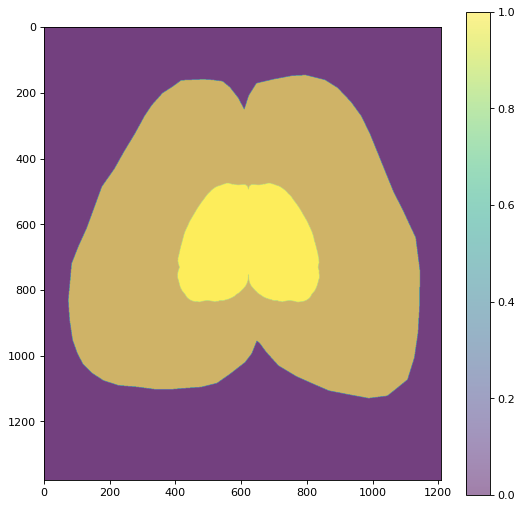

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(warped_isocortex_mask,alpha=0.5)
plt.imshow(ants_surgery_mask.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

## Other tests

In [15]:
ants_surgery_mask = ants.image_read("/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/test1_M36_surgery_mask_v2.nrrd")
ants_surgery_mask = ants.resample_image(ants_surgery_mask, (3,3))

ants_cortex_mask = ants.image_read("/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/cortex.nrrd")

mytx = ants.registration(fixed=ants_surgery_mask, moving=ants_cortex_mask, type_of_transform = ('SyN'), syn_sampling = 8)

In [27]:
ants_contour = ants.image_read("/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/contour.nrrd")

In [28]:
atlas_warped = ants.apply_transforms(ants_surgery_mask, ants_cortex_mask, mytx['fwdtransforms']).numpy()
contours_warped = ants.apply_transforms(ants_surgery_mask, ants_contour, mytx['fwdtransforms']).numpy()

surgery_image = cv2.imread("/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg", cv2.IMREAD_GRAYSCALE)

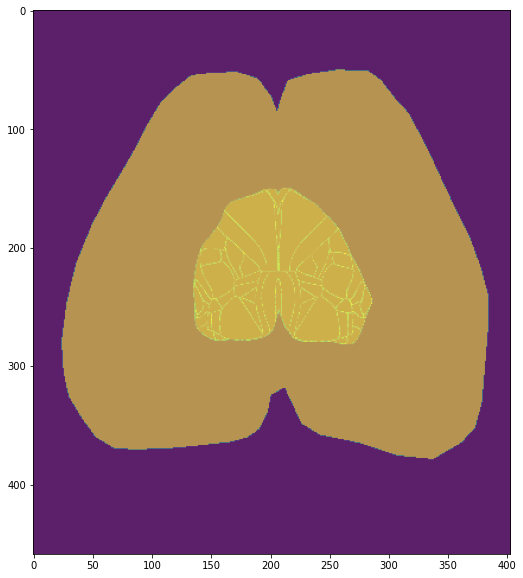

In [31]:
fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(atlas_warped, alpha = 0.5)
plt.imshow(contours_warped, alpha = 0.5)
plt.imshow(ants_surgery_mask.numpy(), alpha = 0.5)
#plt.imshow(surgery_image, alpha = 0.5)

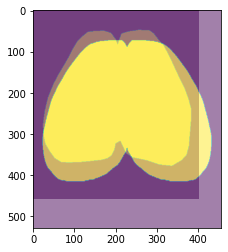

In [20]:
%matplotlib inline

plt.imshow(ants_surgery_mask.numpy(), alpha=0.5)
plt.imshow(ants_cortex_mask.numpy(), alpha=0.5)
plt.show()

# Mélimélo de trucs essayés + code d'il y a 10 mois

In [ ]:
def registration(registrationPath, folderName, fixed_filename, moving_filename, trsfm = 'SyN', sampling = 8, show='off'):
    #Creates new folder at registrationPath with name folderName. If folder already existant, closes function.
    newFolder = registrationPath + "/" + folderName
    
    if os.path.exists(newFolder):
        print(f'{folderName} already exists.')
        if identify_files(newFolder, fixed_filename) == [fixed_filename]:
            tif_to_nrrd(fixed_filename, newFolder)
            tif_to_nrrd(moving_filename, newFolder)
        else:
            print('Insert .tif files in folder before registering.')
            return
    
    else:
        print(f'Creating a folder named {folderName} in {registrationPath}')
        os.mkdir(newFolder)
        
        #Opens fixed and moving images
        print('Opening fixed .tif image')
        fixed = search_path(path_type='file')
        fixedImg = cv2.imread(fixed + "/" + fixed_filename, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(newFolder + '/' + fixed_filename, fixedImg)
        nrrd_fixedname = tif_to_nrrd(fixed_filename, newFolder)
    
    
        print('Opening moving .tif image')
        moving = search_path(path_type='file')
        movingImg = cv2.imread(moving + "/" + moving_filename, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(newFolder + '/' + moving_filename, movingImg)
        nrrd_movingname = tif_to_nrrd(moving_filename, newFolder)
    
    # .tif and .nrrd created.
    
    ants_fixedImg = ants.image_read(newFolder + '/' + nrrd_fixedname)
    ants_movingImg = ants.image_read(newFolder + '/' + nrrd_movingname)
    mytx = ants.registration(fixed=ants_fixedImg, moving=ants_movingImg, type_of_transform = trsfm, syn_sampling = sampling)
    warpedImg = ants.apply_transforms(ants_fixedImg, ants_movingImg, mytx['fwdtransforms']).numpy()
    
    if show == 'on':
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(warpedImg, cmap='PiYG', alpha=0.5)
        plt.imshow(fixedImg, cmap='PuOr', alpha=0.5)
    
    return mytx, ants_fixedImg, ants_movingImg, warpedImg

In [ ]:
path = search_for_file_path()
filename = 'isocortex_churchland.tif'
img_raw = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)
roi_helper = EasyROI(verbose=True)
polygon_roi = roi_helper.draw_polygon(img_raw, 1)
contour, hierarchy = pcv.roi.custom(img=img_raw, vertices=polygon_roi["roi"][0]["vertices"])
mask = pcv.roi.roi2mask(img=img_raw, contour=contour)

In [ ]:
#churchland_nrrd, header = nrrd.read(directory + "/saved_images/isocortex_mask_churchland_int8.nrrd")
#print(header)
#header['space directions'] = np.delete(header['space directions'], 2, 1)
#header['space directions'] = np.array([[30, 0],[0,30]])
#print(header)

In [ ]:
churchland = ants.image_read(directory + "/saved_images/isocortex_churchland_mask_v3.nrrd")
atlas = ants.image_read(directory + "/saved_images/isocortex_mask_int8.nrrd")

In [ ]:
#churchland = ants.image_read(directory + "/saved_images/rot_isocortex_mask_churchland_int8.nrrd")

In [ ]:
#atlas = ants.image_read(directory + "/saved_images/isocortex_mask_int8.nrrd")
contour_ants = ants.image_read("contour.nrrd")

In [ ]:
mytx = ants.registration(fixed=churchland, moving=atlas, type_of_transform = ('SyN'), syn_sampling = 8)

In [ ]:
atlas_warped = ants.apply_transforms(churchland, atlas, mytx['fwdtransforms']).numpy()
contours_warped = ants.apply_transforms(churchland, contour_ants, mytx['fwdtransforms']).numpy()z

In [ ]:
path = search_for_file_path()
filename = 'isocortex_churchland.tif'
img = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(atlas_warped, alpha=0.5)
plt.imshow(contours_warped, cmap='binary_r', alpha=0.8)
#plt.imshow(churchland.numpy(), alpha=0.5)
plt.imshow(img, cmap='binary_r', alpha=0.6)

In [ ]:
registrationPath = search_path()

## (select_mask function)

In [12]:
def select_mask(image):
    
    print('Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.')
    # Initialize variables
    roi_points = []
    roi_completed = False

    def mouse_callback(event, x, y, flags, param):
        nonlocal roi_points, roi_completed
        
        

        if event == cv2.EVENT_LBUTTONDOWN:
            roi_points.append((x, y))
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)

            if len(roi_points) > 1:
                cv2.line(image, roi_points[-2], roi_points[-1], (0, 0, 255), 5)


    # Create a window to display the image
    cv2.namedWindow('Select ROI')
    cv2.imshow('Select ROI', image)

    # Register the mouse callback function
    cv2.setMouseCallback('Select ROI', mouse_callback)
    while not roi_completed:
        cv2.imshow('Select ROI', image)
        key = cv2.waitKey(10)
        
        if key == 27:
            roi_completed = True

    

    # Convert the ROI points to a NumPy array
    roi_points = np.array(roi_points)

    # Create a binary mask
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    cv2.fillPoly(mask, [roi_points], 1)
    
    cv2.destroyWindow('Select ROI')
    cv2.destroyAllWindows()
    return mask